In [1]:
### R 4.0.3 & seurat 4.0.1
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(Seurat)
  library(ggsci)
  library(ggplot2)
  library(dplyr)
  library(Matrix)
  library(pheatmap)
  library(ggpubr)
  library(plotly)
  library(RColorBrewer)
  library(scales)
  library(readr)
  library(reshape2)
  library(ggbeeswarm)
  # DTUrtle v1.0.2
  library(edgeR)
  library(SummarizedExperiment)
  library(stageR)
  library(DTUrtle)
  library(VennDiagram)
  library(eulerr)
  # use up to 10 cores for computation
  biocpar <- BiocParallel::MulticoreParam(10)
})

In [ ]:
mytheme <- ggplot2::theme(
  plot.background = element_blank(),
  panel.background = element_rect(fill = "#FFFFFF"),
  legend.background = element_blank(),
  legend.box.background = element_blank(),
  panel.border = element_rect(linetype = "solid", colour = "black", fill = NA, size = 0.5),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  axis.line = element_blank(), axis.text = element_text(colour = "black")
)

dimplot_theme <- mytheme + theme(
  legend.text = element_text(size = 20), plot.title = element_blank(),
  axis.text = element_blank(), axis.ticks = element_blank(), aspect.ratio = 1
)

featureplot_theme <- mytheme + theme(
  panel.grid.major = element_blank(),
  axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank(), aspect.ratio = 1
) + NoLegend()

color <- c(c(pal_d3("category20")(20), "#B52D73", "#4347B5", "#4FED28", "#402727", "#48959C", "#FC6262", "#4A9EFF", "#9E969E"))
# specify colors
data_color <- c("#197EC0FF", "#ff8000")
tissue_color <- c("#2CA02CFF", "#E377C2FF")
celltype1_color <- c("#0072B5FF", "#D62728FF") # c(pal_nejm("default")(8)[c(2,1)])
celltype2_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF")
celltype3_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF", "#ff7f00", "#ffff33", "#8A9197FF")
celltype4_color <- c("#20854EFF", "#008EA0FF", "#FF6F00FF", "#C71000FF")

patient_color <- c(
  "#FED439FF", "#8A9197FF", "#8A4198FF", "#D5E4A2FF", "#197EC0FF", "#FD7446FF", "#46732EFF", "#71D0F5FF", "#E377C2FF",
  "#075149FF", "#e60000", "#91331FFF", "#1A9993FF", "#ff80aa", "#D2AF81FF", "#370335FF", "#cc99ff", "#ff8000", "#59b300"
)

In [29]:
ont <- readRDS(file = "../CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
ont <- subset(ont, cells = ont@meta.data[which(ont@meta.data$celltype3 %in% c("Stem/TA", "Stem/TA-like")), ]$CellName)
ont

An object of class Seurat 
51718 features across 2679 samples within 4 assays 
Active assay: UTR3 (4609 features, 0 variable features)
 3 other assays present: RNA, GENE, UTR5
 3 dimensional reductions calculated: pca, tsne, umap

# Perform DTU using Dturtle

In [ ]:
tx_info <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category_expression_proportion.txt", header = T, sep = "\t")
head(tx_info, 1)

In [ ]:
# transcript_name is unique，first two columns: transcript and gene
tx2gene <- tx_info[, c("TranName", "GeneName")]
rownames(tx2gene) <- tx2gene$TranName
# tx2gene <- move_columns_to_front(tx2gene, columns = c("TranName","GeneName"))
dim(tx2gene)
head(tx2gene, 2)

In [9]:
# isoform
system.time(tx_counts <- read_csv(
  "../../CRC_HTCRC_01_RNA_QC/00_tx_counts_qc_500_genenumbersgt0_5400_3262.csv"
))
tx_counts <- as.data.frame(tx_counts)
rownames(tx_counts) <- tx_counts[, 1]
tx_counts <- tx_counts[, 2:ncol(tx_counts)]
dim(tx_counts)
head(tx_counts, 2)

New names:
• `` -> `...1`
Rows: 29429 Columns: 3263
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): ...1
dbl (3262): CRC01_L1_Barcode01, CRC01_L1_Barcode02, CRC01_L1_Barcode03, CRC0...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


   user  system elapsed 
 29.013   3.892   7.094 

[1] 29429  3262

,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode11,CRC01_L1_Barcode12,⋯,HTCRC05_PT2_Bc96_Bc34,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7SK.1-201,0,0,0,0.990937,1.984894,0,0,0,3.567976,0,⋯,0,0,4.712991,2.975831,0,1,0,9.963746,1,0
A1CF-202,0,0,0,0.000000,0.000000,0,0,0,0.000000,0,⋯,0,0,0.000000,0.000000,0,0,0,0.000000,0,0


In [10]:
tx_counts <- tx_counts[, ont@meta.data$CellName]

cts <- combine_to_matrix(tx_list = list(
  ont_crc = Matrix(as.matrix(tx_counts), sparse = TRUE)
))
dim(cts)

Merging matrices

Excluding 32 overall not expressed features.

29397 features left.



[1] 29397  2679

In [ ]:
## when performing DTU for each patient in CRC, all stem/TA cells of CRC(9 patients) were used
## when performing HTCRC for each patient, Stem/TA cells of HTCRC (3 patients) were used

In [30]:
ont@meta.data$celltype3_1 <- paste0(as.character(ont@meta.data$celltype3), "_", as.character(ont@meta.data$patient))
ont@meta.data[which(ont@meta.data$celltype3 %in% "Stem/TA"), ]$celltype3_1 <- "Stem/TA"
table(ont@meta.data$celltype3_1)


             Stem/TA   Stem/TA-like_CRC01   Stem/TA-like_CRC02 
                 359                  121                   66 
  Stem/TA-like_CRC03   Stem/TA-like_CRC04   Stem/TA-like_CRC05 
                  60                   57                  130 
  Stem/TA-like_CRC07   Stem/TA-like_CRC08   Stem/TA-like_CRC09 
                 186                  107                  132 
  Stem/TA-like_CRC10 Stem/TA-like_HTCRC01 Stem/TA-like_HTCRC04 
                  73                  413                  517 
Stem/TA-like_HTCRC05 
                 458 

In [33]:
# DTU in each patient
dturtle.list <- list()
ont_crc <- subset(ont, cells = (ont@meta.data %>% filter(data %in% "CRC"))$CellName)
ont_htcrc <- subset(ont, cells = (ont@meta.data %>% filter(data %in% "HTCRC"))$CellName)

for (i in c(2:13)) {
  p <- names(table(ont@meta.data$celltype3_1))[i]
  print(p)

  # Determine which dataset and conditions to use based on `i`
  if (i %in% 2:10) { # 9 patients of CRC data
    mysub <- ont_crc
    mycts <- cts[, ont_crc@meta.data$CellName]
  } else {
    mysub <- ont_htcrc
    mycts <- cts[, ont_htcrc@meta.data$CellName]
  }

  dturtle <- run_drimseq( # DTU analysis takes more than 2h
    counts = mycts, tx2gene = tx2gene, pd = mysub@meta.data, id_col = "CellName",
    cond_col = "celltype3_1", cond_levels = c(p, "Stem/TA"), filtering_strategy = "sc", BPPARAM = biocpar
  )
  dturtle <- posthoc_and_stager(dturtle = dturtle, ofdr = 0.05, posthoc = 0.1)
  # DTU table creation
  dturtle <- create_dtu_table(
    dturtle = dturtle, # add_gene_metadata = list("exp_in_NE"="exp_in_NE","exp_in_CC"="exp_in_CC"),
    add_tx_metadata = list("tx_expr_in_max" = c("exp_in", max))
  )
  saveRDS(dturtle, file = sprintf("dturtle_%s.rds", sapply(strsplit(p, split = "_"), function(x) {
    x[2]
  })))
  dturtle.list[[p]] <- dturtle
}

[1] "Stem/TA-like_CRC01"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC01' vs 'Stem/TA'

Excluding 811 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC01            Stem/TA 
               121                191 


Filtering...




  |======================================================================| 100%



Retain 18660 of 29175 features.
Removed 10515 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.669953 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 3129 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 945 significant genes with 1395 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_CRC02"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC02' vs 'Stem/TA'

Excluding 866 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC02            Stem/TA 
                66                191 


Filtering...




  |======================================================================| 100%



Retain 20007 of 28966 features.
Removed 8959 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.424675 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 4065 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 124 significant genes with 145 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_CRC03"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC03' vs 'Stem/TA'

Excluding 872 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC03            Stem/TA 
                60                191 


Filtering...




  |======================================================================| 100%



Retain 21011 of 28900 features.
Removed 7889 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.386439 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


! Using 0.41952 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 5405 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


[1] "Stem/TA-like_CRC05"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC05' vs 'Stem/TA'

Excluding 802 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC05            Stem/TA 
               130                191 


Filtering...




  |======================================================================| 100%



Retain 19625 of 29162 features.
Removed 9537 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.918132 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 3473 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 1054 significant genes with 1568 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_CRC07"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC07' vs 'Stem/TA'

Excluding 746 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC07            Stem/TA 
               186                191 


Filtering...




  |======================================================================| 100%



Retain 17186 of 29163 features.
Removed 11977 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.70763 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 2483 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 682 significant genes with 1008 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_CRC08"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC08' vs 'Stem/TA'

Excluding 825 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC08            Stem/TA 
               107                191 


Filtering...




  |======================================================================| 100%



Retain 18611 of 29100 features.
Removed 10489 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.768095 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 3262 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 172 significant genes with 225 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_CRC09"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC09' vs 'Stem/TA'

Excluding 800 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC09            Stem/TA 
               132                191 


Filtering...




  |======================================================================| 100%



Retain 17701 of 28985 features.
Removed 11284 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.656884 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 2801 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 191 significant genes with 239 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_CRC10"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_CRC10' vs 'Stem/TA'

Excluding 859 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_CRC10            Stem/TA 
                73                191 


Filtering...




  |======================================================================| 100%



Retain 21087 of 29095 features.
Removed 8008 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using 0.711632 as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 4755 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 1078 significant genes with 1491 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_HTCRC01"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_HTCRC01' vs 'Stem/TA'

Excluding 975 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_HTCRC01              Stem/TA 
                 413                  168 


Filtering...




  |======================================================================| 100%



Retain 13173 of 27351 features.
Removed 14178 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 8.1306 as prec_init !


* Estimating genewise precision.. 


! Using loess fit as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 4012 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 365 significant genes with 539 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_HTCRC04"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_HTCRC04' vs 'Stem/TA'

Excluding 871 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_HTCRC04              Stem/TA 
                 517                  168 


Filtering...




  |======================================================================| 100%



Retain 15424 of 28090 features.
Removed 12666 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 13.1556 as prec_init !


* Estimating genewise precision.. 


! Using loess fit as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 4697 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 846 significant genes with 1395 significant transcripts (OFDR: 0.05)



[1] "Stem/TA-like_HTCRC05"


Using tx2gene columns:
	TranName ---> 'feature_id'
	GeneName ---> 'gene_id'


Comparing in 'celltype3_1': 'Stem/TA-like_HTCRC05' vs 'Stem/TA'

Excluding 930 cells/samples for this comparison!


Proceed with cells/samples: 
Stem/TA-like_HTCRC05              Stem/TA 
                 458                  168 


Filtering...




  |======================================================================| 100%



Retain 14108 of 27849 features.
Removed 13741 features.


Performing statistical tests...


* Calculating mean gene expression.. 


* Estimating common precision.. 


! Using common_precision = 4.7973 as prec_init !


* Estimating genewise precision.. 


! Using loess fit as a shrinkage factor !


* Fitting the DM model.. 


   Using the one way approach. 


* Fitting the BB model.. 


   Using the one way approach. 


* Fitting the DM model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


* Fitting the BB model.. 


   Using the one way approach. 


* Calculating likelihood ratio statistics.. 


Posthoc filtered 3546 features.

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


Found 142 significant genes with 201 significant transcripts (OFDR: 0.05)



In [83]:
saveRDS(dturtle.list, file = "00_dturtle.list_StemTA.rds")

# DTU result

In [10]:
dturtle.list <- readRDS(file = "00_dturtle.list_StemTA.rds")

In [12]:
names(dturtle.list)

[1] "Stem/TA-like_CRC01"   "Stem/TA-like_CRC02"   "Stem/TA-like_CRC03"  
 [4] "Stem/TA-like_CRC04"   "Stem/TA-like_CRC05"   "Stem/TA-like_CRC07"  
 [7] "Stem/TA-like_CRC08"   "Stem/TA-like_CRC09"   "Stem/TA-like_CRC10"  
[10] "Stem/TA-like_HTCRC01" "Stem/TA-like_HTCRC04" "Stem/TA-like_HTCRC05"

In [13]:
# meta_table_gene: Contains gene level meta data.
# meta_table_tx: Contains transcript level meta data
# meta_table_sample: Contains sample level meta data
head(dturtle.list[["Stem/TA-like_CRC01"]]$meta_table_gene, 2)
head(dturtle.list[["Stem/TA-like_CRC01"]]$meta_table_tx, 2)

,gene,exp_in,exp_in_Stem/TA-like_CRC01,exp_in_Stem/TA
,<chr>,<dbl>,<dbl>,<dbl>
A1CF,A1CF,0.4935897,0.4710744,0.5078534
AAAS,AAAS,0.4262821,0.5206612,0.3664921


,gene,tx,exp_in,exp_in_Stem/TA-like_CRC01,exp_in_Stem/TA
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
A1CF-202,A1CF,A1CF-202,0.08974359,0.16528926,0.04188482
A1CF-204,A1CF,A1CF-204,0.03205128,0.03305785,0.03141361


## merge sig_gene results

In [14]:
for (p in names(dturtle.list)) {
  print(p)
  dtu_table <- dturtle.list[[p]]$dtu_table
  colnames(dtu_table) <- c("GeneName", "gene_qvalue", "minimal_tx_qvalue", "number_tx", "number_significant_tx", "max(Stem/TA-like-Stem/TA)", "pct_gene_expr", "tx_expr_in_max")
  dtu_table$patient <- p
  if (p %in% names(dturtle.list)[1]) {
    dtu_gene_rbind <- dtu_table
  } else {
    dtu_gene_rbind <- rbind(dtu_gene_rbind, dtu_table)
  }
}

[1] "Stem/TA-like_CRC01"
[1] "Stem/TA-like_CRC02"
[1] "Stem/TA-like_CRC03"
[1] "Stem/TA-like_CRC04"
[1] "Stem/TA-like_CRC05"
[1] "Stem/TA-like_CRC07"
[1] "Stem/TA-like_CRC08"
[1] "Stem/TA-like_CRC09"
[1] "Stem/TA-like_CRC10"
[1] "Stem/TA-like_HTCRC01"
[1] "Stem/TA-like_HTCRC04"
[1] "Stem/TA-like_HTCRC05"


In [15]:
dtu_gene_rbind <- dtu_gene_rbind %>%
  group_by(GeneName) %>%
  mutate(DTU_gene_nPatients = length(patient), max_in_allpatients = max(abs(`max(Stem/TA-like-Stem/TA)`))) %>%
  arrange(desc(DTU_gene_nPatients), desc(max_in_allpatients), gene_qvalue)
dtu_gene_rbind$patient <- sapply(strsplit(dtu_gene_rbind$patient, split = "_"), function(x) {
  x[2]
})

head(dtu_gene_rbind, 1)

GeneName,gene_qvalue,minimal_tx_qvalue,number_tx,number_significant_tx,max(Stem/TA-like-Stem/TA),pct_gene_expr,tx_expr_in_max,patient,DTU_gene_nPatients,max_in_allpatients
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
RPS14,1.280661e-20,5.35024e-20,3,3,-0.1962087,0.983871,0.9717742,CRC04,12,0.1962087


In [16]:
write.table(dtu_gene_rbind, file = "00_StemTA_DTU_gene_rbind_each_patient.txt", quote = F, row.names = F, sep = "\t")

## merge sig_tx result

In [18]:
for (p in names(dturtle.list)) {
  fdr_table <- dturtle.list[[p]]$FDR_table
  fdr_table <- fdr_table[!is.na(fdr_table$transcript), c("txID", "transcript")]
  colnames(fdr_table) <- c("TranName", "tx_fdr")
  fdr_table$patient <- p

  if (p %in% names(dturtle.list)[1]) {
    dtu_tx_rbind <- fdr_table
  } else {
    dtu_tx_rbind <- rbind(dtu_tx_rbind, fdr_table)
  }
}

In [19]:
dtu_tx_rbind <- dtu_tx_rbind %>%
  group_by(TranName) %>%
  mutate(DTU_tx_nPatients = length(patient)) %>%
  arrange(desc(DTU_tx_nPatients), tx_fdr)
dtu_tx_rbind$patient <- sapply(strsplit(dtu_tx_rbind$patient, split = "_"), function(x) {
  x[2]
})

dim(dtu_tx_rbind)
head(dtu_tx_rbind, 3)

[1] 25383     4

TranName,tx_fdr,patient,DTU_tx_nPatients
<chr>,<dbl>,<chr>,<int>
HLA-C-201,2.393202e-31,HTCRC04,12
HLA-C-208,3.908262e-20,HTCRC04,12
RPS14-201,5.350240e-20,CRC04,12


In [24]:
dtu_tx_rbind <- merge(dtu_tx_rbind, tx_info[, c("TranName", "GeneName")], by = "TranName", all.x = T)

In [26]:
dtu_tx_rbind <- merge(dtu_tx_rbind, dtu_gene_rbind, by = c("GeneName", "patient"), all.x = T)

In [27]:
write.table(dtu_tx_rbind, file = "00_StemTA_DTU_tx_rbind_each_patient.txt", quote = F, sep = "\t", row.names = F)

## gene TPM

In [34]:
cell_info <- ont@meta.data[, c("CellName", "patient", "celltype3_1", "data")]
cell_info$celltype3_1 <- as.character(cell_info$celltype3_1)
cell_info[which(cell_info$celltype3_1 %in% "Stem/TA"), ]$celltype3_1 <- paste0(
  "Stem/TA_", cell_info[which(cell_info$celltype3_1 %in% "Stem/TA"), ]$data
)

In [36]:
gene_tpm_qc <- read.csv(file = "../../CRC_HTCRC_01_RNA_QC/00_gene_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
gene_tpm_qc <- gene_tpm_qc[unique(dtu_tx_rbind$GeneName), cell_info$CellName]
dim(gene_tpm_qc)

[1] 2726 2679

In [37]:
gene_tpm_long <- gene_tpm_qc %>%
  tibble::rownames_to_column(var = "GeneName") %>%
  tidyr::pivot_longer(cols = -GeneName, names_to = "CellName", values_to = "TPM") %>%
  left_join(cell_info, by = "CellName")

In [38]:
write.table(gene_tpm_long, file = "00_gene_tpm_LongFormat_in_celltype3_each_patient.txt", sep = "\t", quote = F, row.names = F)

In [39]:
gene_tpm_avg <- gene_tpm_long %>%
  group_by(patient, celltype3_1, GeneName) %>%
  summarise(mean_TPM_gene = mean(TPM, na.rm = T), .groups = "drop") %>%
  as.data.frame()

In [40]:
gene_tpm_avg$celltype3 <- sapply(strsplit(gene_tpm_avg$celltype3_1, split = "_"), function(x) {
  x[1]
})
gene_tpm_avg <- dcast(gene_tpm_avg, GeneName + patient ~ celltype3, value.var = "mean_TPM_gene")
colnames(gene_tpm_avg) <- c("GeneName", "patient", "ave_gene_TPM_Stem/TA", "ave_gene_TPM_Stem/TA-like")

In [41]:
write.table(gene_tpm_avg, file = "00_gene_tpm_average_in_celltype3_each_patient.txt", sep = "\t", quote = F, row.names = F)

## tx TPM proportion

In [46]:
tx_tpm_qc <- read.csv(file = "../../CRC_HTCRC_01_RNA_QC/00_tx_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
tx_tpm_qc <- tx_tpm_qc[
  (tx_info %>% filter(GeneName %in% unique(dtu_tx_rbind$GeneName)))$TranName,
  cell_info$CellName
]
dim(tx_tpm_qc)

[1] 10993  2679

In [ ]:
# Convert tx_tpm_qc to the long format and merge the cell annotation information
tx_tpm_long <- tx_tpm_qc %>%
  tibble::rownames_to_column(var = "TranName") %>%
  tidyr::pivot_longer(cols = -TranName, names_to = "CellName", values_to = "TPM") %>%
  left_join(cell_info, by = "CellName")
dim(tx_tpm_long)

In [ ]:
head(tx_tpm_long)

,TranName,CellName,TPM,patient,celltype3_1,data,GeneName
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,AAAS-201,CRC01_L1_Barcode01,0.00000,CRC01,Stem/TA_CRC,CRC,AAAS
2,AAAS-201,CRC01_L1_Barcode08,267.32166,CRC01,Stem/TA_CRC,CRC,AAAS
3,AAAS-201,CRC01_L1_Barcode09,0.00000,CRC01,Stem/TA_CRC,CRC,AAAS
4,AAAS-201,CRC01_L1_Barcode10,43.12358,CRC01,Stem/TA_CRC,CRC,AAAS
5,AAAS-201,CRC01_L1_Barcode17,0.00000,CRC01,Stem/TA_CRC,CRC,AAAS
6,AAAS-201,CRC01_L1_Barcode21,0.00000,CRC01,Stem/TA_CRC,CRC,AAAS


In [52]:
tx_tpm_long <- merge(tx_tpm_long, tx_info[, c("TranName", "GeneName")], by = "TranName", all.x = T)
dim(tx_tpm_long)

[1] 29450247        7

In [54]:
tx_tpm_long <- tx_tpm_long %>%
  group_by(CellName, GeneName) %>%
  mutate(Proportion = TPM / sum(TPM))

In [55]:
write.table(tx_tpm_long, file = "00_tx_tpm_prop_LongFormat_in_celltype3_each_patient.txt", sep = "\t", quote = F, row.names = F)

In [56]:
# Calculate the average TPM of each isoform for each patient and each cell type
tx_avg <- tx_tpm_long %>%
  filter(!is.na(Proportion)) %>%
  group_by(patient, celltype3_1, TranName) %>%
  summarise(mean_TPM_tx = mean(TPM, na.rm = TRUE), mean_Prop_tx = mean(Proportion, na.rm = TRUE), .groups = "drop") %>%
  as.data.frame()

In [57]:
tx_avg$celltype3 <- sapply(strsplit(tx_avg$celltype3_1, split = "_"), function(x) {
  x[1]
})

In [58]:
tx_tpm_avg <- dcast(tx_avg, TranName + patient ~ celltype3, value.var = "mean_TPM_tx")
colnames(tx_tpm_avg) <- c("TranName", "patient", "ave_tx_TPM_Stem/TA", "ave_tx_TPM_Stem/TA-like")

In [59]:
tx_prop_avg <- dcast(tx_avg, TranName + patient ~ celltype3, value.var = "mean_Prop_tx")
colnames(tx_prop_avg) <- c("TranName", "patient", "ave_tx_Prop_Stem/TA", "ave_tx_Prop_Stem/TA-like")

In [60]:
tx_avg <- merge(tx_tpm_avg, tx_prop_avg, by = c("TranName", "patient"))

In [61]:
write.table(tx_avg, file = "00_tx_tpm_prop_average_in_celltype3_each_patient.txt", sep = "\t", quote = F, row.names = F)

In [63]:
dtu_tx_rbind <- merge(dtu_tx_rbind, tx_avg, by = c("TranName", "patient"), all.x = T)
dtu_tx_rbind$ave_tx_Prop_stemTAlike_minus_stemTA <- round(dtu_tx_rbind$`ave_tx_Prop_Stem/TA-like` - dtu_tx_rbind$`ave_tx_Prop_Stem/TA`, 3)

In [69]:
dtu_tx_rbind <- merge(dtu_tx_rbind, gene_tpm_avg, by = c("GeneName", "patient"), all.x = T)
dim(dtu_tx_rbind)

[1] 25383    21

In [71]:
all(sort(colnames(dtu_tx_rbind)) == sort(c(
  "GeneName", "TranName", "patient", "ave_tx_Prop_stemTAlike_minus_stemTA", "max_in_allpatients", "max(Stem/TA-like-Stem/TA)",
  "DTU_tx_nPatients", "DTU_gene_nPatients", "tx_fdr", "gene_qvalue", "minimal_tx_qvalue",
  "ave_tx_TPM_Stem/TA", "ave_tx_TPM_Stem/TA-like", "ave_tx_Prop_Stem/TA", "ave_tx_Prop_Stem/TA-like",
  "ave_gene_TPM_Stem/TA", "ave_gene_TPM_Stem/TA-like",
  "number_tx", "number_significant_tx", "pct_gene_expr", "tx_expr_in_max"
)))

[1] TRUE

In [72]:
dtu_tx_rbind <- dtu_tx_rbind[, c(
  "GeneName", "TranName", "patient", "ave_tx_Prop_stemTAlike_minus_stemTA", "max_in_allpatients", "max(Stem/TA-like-Stem/TA)",
  "DTU_tx_nPatients", "DTU_gene_nPatients", "tx_fdr", "gene_qvalue", "minimal_tx_qvalue",
  "ave_tx_TPM_Stem/TA", "ave_tx_TPM_Stem/TA-like", "ave_tx_Prop_Stem/TA", "ave_tx_Prop_Stem/TA-like",
  "ave_gene_TPM_Stem/TA", "ave_gene_TPM_Stem/TA-like",
  "number_tx", "number_significant_tx", "pct_gene_expr", "tx_expr_in_max"
)] %>%
  arrange(desc(DTU_tx_nPatients), desc(DTU_gene_nPatients), desc(max_in_allpatients), desc(abs(`max(Stem/TA-like-Stem/TA)`)), tx_fdr)

In [73]:
dim(dtu_tx_rbind)
length(unique(dtu_tx_rbind$GeneName))
length(unique(dtu_tx_rbind$TranName))

[1] 25383    21

[1] 2726

[1] 10099

In [74]:
write.table(dtu_tx_rbind, file = "01_DTU_tx_each_patient.txt", quote = F, sep = "\t", row.names = F)

# Filtering DTU result and plot Upset

In [6]:
library(ComplexUpset)

In [78]:
df_merge <- read.table(file = "01_DTU_tx_each_patient.txt", header = T, sep = "\t", check.names = F)
df_merge_filter <- df_merge %>%
  filter(abs(`max(Stem/TA-like-Stem/TA)`) >= 0.095, tx_fdr < 0.05, gene_qvalue < 0.05, abs(ave_tx_Prop_stemTAlike_minus_stemTA) >= 0.095) %>%
  group_by(TranName) %>%
  mutate(P_ave_tx_Prop_stemTAlike_minus_stemTA = mean(ave_tx_Prop_stemTAlike_minus_stemTA)) %>%
  as.data.frame()
length(unique(df_merge_filter$TranName))
length(unique(df_merge_filter$GeneName))

[1] 3548

[1] 1946

In [79]:
df_merge_filter <- df_merge_filter %>%
  group_by(GeneName, TranName) %>%
  mutate(DTU_tx_nPatients_1 = length(patient))

In [80]:
write.table(df_merge_filter, file = "02_DTU_tx_each_patient_final_DTUgenes.txt", quote = F, sep = "\t", row.names = F)

In [ ]:
df_merge_filter <- read.table(file = "02_DTU_tx_each_patient_final_DTUgenes.txt", sep = "\t", header = T)

## upset plot

In [81]:
df_gdtu <- df_merge_filter[, c("GeneName", "patient")] %>% distinct()
length(unique(df_gdtu$GeneName))
table(df_gdtu$patient)

[1] 1946


  CRC01   CRC02   CRC03   CRC04   CRC05   CRC07   CRC08   CRC09   CRC10 HTCRC01 
    483      64     142     316     514     371      96     106     621     207 
HTCRC04 HTCRC05 
    642      74 

In [82]:
# Create a binary presence/absence matrix
df_gdtu_summary <- df_gdtu %>%
  group_by(GeneName, patient) %>%
  summarise(count = n()) %>%
  ungroup() %>%
  mutate(present = ifelse(count > 0, 1, 0)) %>%
  dplyr::select(GeneName, patient, present) %>%
  tidyr::spread(key = patient, value = present, fill = 0)

# Convert to a format suitable for ComplexUpset
df_gdtu_summary <- as.data.frame(df_gdtu_summary)

`summarise()` has grouped output by 'GeneName'. You can override using the `.groups` argument.


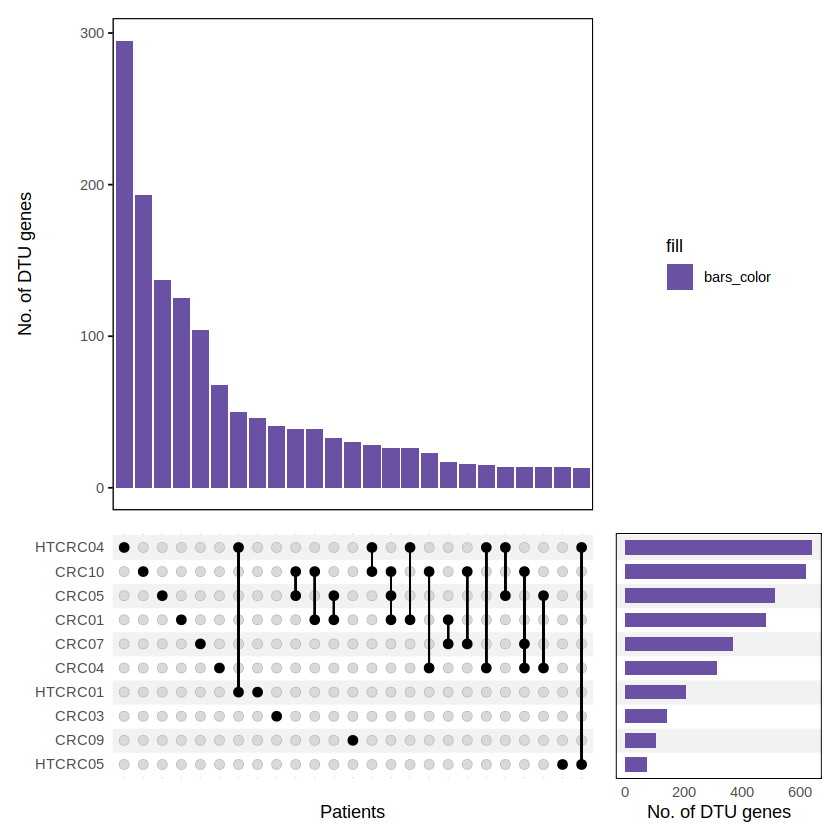

In [85]:
# pdf(file="02_DTU_tx_each_patient_final_DTUgenes_upset.pdf", width = 5.5, height = 4.5)
upset(
  df_gdtu_summary,
  names(table(df_gdtu$patient)),
  name = "Patients",
  width_ratio = 0.3,
  n_intersections = 25,
  set_sizes = (
    upset_set_size(mapping = aes(fill = "bars_color"), position = "right") +
      labs(y = "No. of DTU genes") + mytheme + scale_fill_manual(values = "#6a51a3")
  ),
  base_annotations = list(
    "No. of DTU genes" = intersection_size(counts = FALSE, mapping = aes(fill = "bars_color")) +
      scale_fill_manual(values = "#6a51a3") + mytheme + theme(axis.ticks.y = element_line(color = "black")) #+Nolend()
  ),
  matrix = intersection_matrix(
    geom = geom_point(size = 2)
  ),
  guides = "over"
) + mytheme
# dev.off()

## volcano plot

In [69]:
library(ggrepel)

In [70]:
df_merge_filter <- read.table(file = "02_DTU_tx_each_patient_final_DTUgenes.txt", header = T, sep = "\t", check.names = F)

In [71]:
test <- df_merge_filter[, c("GeneName", "TranName", "patient", "ave_tx_Prop_stemTAlike_minus_stemTA", "DTU_gene_nPatients", "tx_fdr", "DTU_tx_nPatients", "DTU_tx_nPatients_1")] %>%
  group_by(GeneName, TranName) %>%
  summarise(
    ratio = mean(ave_tx_Prop_stemTAlike_minus_stemTA),
    fdr = min(tx_fdr),
    DTU_tx_nPatients_1 = unique(DTU_tx_nPatients_1),
    .groups = "drop"
  )
test[which(test$fdr == 0), ]$fdr <- unique(sort(test$fdr))[2]
test <- test %>% arrange(DTU_tx_nPatients_1)

In [74]:
test <- test %>% filter(ratio <= -0.1 | ratio >= 0.1)

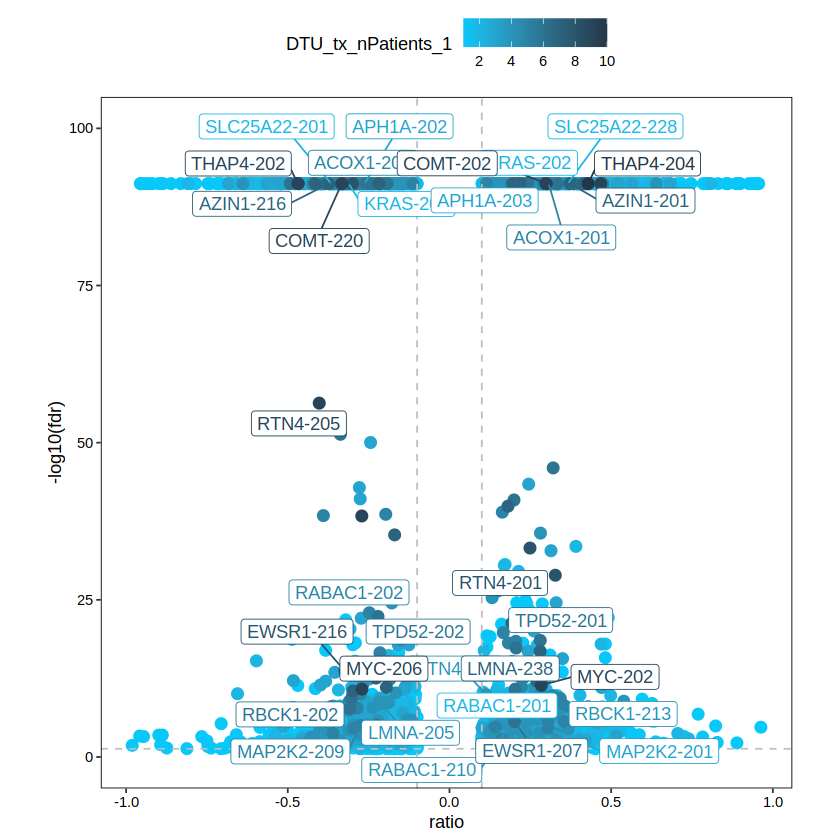

In [76]:
ggplot(test, aes(x = ratio, y = -log10(fdr), color = DTU_tx_nPatients_1)) +
  geom_point(size = 3) +
  mytheme +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_label_repel(
    data = test %>% filter(GeneName %in% c(
      "THAP4", "MYC", "EWSR1", "AZIN1", "COMT", "RTN4", "RBCK1", "APH1A", "SLC25A22", "RABAC1", #' LUC7L2','CLDN7',
      "TPD52", "LMNA", "ACOX1", "MAP2K2", "KRAS"
    )) %>% filter(TranName != "LMNA-NIC.1") %>% filter(DTU_tx_nPatients_1 > 1),
    aes(label = TranName), max.overlaps = Inf
  ) +
  theme(legend.position = "top") +
  scale_color_gradient(low = "#07c8f9", high = "#243748", breaks = c(2, 4, 6, 8, 10), labels = c("2", "4", "6", "8", "10")) +
  theme(aspect.ratio = 1) +
  ylim(0, 100)
ggsave(file = "02_DTU_tx_each_patient_final_DTUgenes_volcano.pdf", width = 5, height = 6)

## example boxplot

In [155]:
df_merge_filter <- read.table(file = "01_DTU_tx_each_patient.txt", header = T, sep = "\t", check.names = F)

In [2]:
# see 00_DTU_plot.ipynb

# Venn plot, the intersection of DEG，DTE and AS genes

## DEGs of each patient

In [18]:
ont <- readRDS(file = "../CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
DefaultAssay(ont) <- "GENE"
ont <- subset(ont, cells = (ont@meta.data %>% filter(celltype3 %in% c("Stem/TA", "Stem/TA-like")))$CellName)
ont_crc <- subset(ont, cells = (ont@meta.data %>% filter(data %in% "CRC"))$CellName)
ont_htcrc <- subset(ont, cells = (ont@meta.data %>% filter(data %in% "HTCRC"))$CellName)

In [106]:
for (i in c(1:12)) {
  p <- names(table(ont@meta.data$patient))[i]
  print(p)
  if (i %in% c(1:9)) {
    ont_p <- subset(ont_crc, cells = c(
      (ont_crc@meta.data %>% filter(celltype3 %in% "Stem/TA"))$CellName,
      (ont_crc@meta.data %>% filter(celltype3 %in% "Stem/TA-like", patient %in% p))$CellName
    ))
  } else {
    ont_p <- subset(ont_htcrc, cells = c(
      (ont_htcrc@meta.data %>% filter(celltype3 %in% "Stem/TA"))$CellName,
      (ont_htcrc@meta.data %>% filter(celltype3 %in% "Stem/TA-like", patient %in% p))$CellName
    ))
  }
  ont_p <- NormalizeData(ont_p, normalization.method = "LogNormalize", scale.factor = 1000000)
  ont_p <- ScaleData(ont_p, features = rownames(ont_p))

  Idents(object = ont_p) <- as.factor(ont_p@meta.data$celltype3)
  deg_p <- FindAllMarkers(ont_p, only.pos = TRUE, min.pct = 0.25, logfc.threshold = log2(2))
  deg_p <- deg_p[which(deg_p$p_val_adj < 0.05), ]
  deg_p$patient <- p

  if (i == 1) {
    deg <- deg_p
  } else {
    deg <- rbind(deg, deg_p)
  }
}

[1] "CRC01"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC02"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC03"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC04"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC05"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC07"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC08"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC09"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC10"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "HTCRC01"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "HTCRC04"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "HTCRC05"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



In [107]:
df_deg_dtu <- data.frame(
  patient = character(),
  p_deg_count = integer(),
  p_dtu_count = integer(),
  overlap_count = integer(),
  stringsAsFactors = FALSE
)
for (i in c(1:12)) {
  p <- names(table(ont@meta.data$patient))[i]
  p_deg <- unique((deg %>% filter(patient %in% p))$gene)
  p_dtu <- unique((df_merge_filter %>% filter(patient %in% p))$GeneName)
  p_overlap <- length(intersect(p_deg, p_dtu))

  df_deg_dtu <- rbind(df_deg_dtu, data.frame(
    patient = p,
    p_deg_count = length(p_deg),
    p_dtu_count = length(p_dtu),
    overlap_count = p_overlap
  ))
}

In [108]:
df_deg_dtu$patient <- factor(df_deg_dtu$patient, levels = names(table(ont@meta.data$patient)))

df_deg_dtu$p_dtu_notoverlap_prop <- (df_deg_dtu$p_dtu_count - df_deg_dtu$overlap_count) / df_deg_dtu$p_dtu_count
df_deg_dtu$p_dtu_overlap_prop <- df_deg_dtu$overlap_count / df_deg_dtu$p_dtu_count
df_deg_dtu_bar <- melt(df_deg_dtu, id.vars = "patient", measure.vars = c("p_dtu_notoverlap_prop", "p_dtu_overlap_prop"))

df_deg_dtu$p_deg_notoverlap_prop <- (df_deg_dtu$p_deg_count - df_deg_dtu$overlap_count) / df_deg_dtu$p_deg_count
df_deg_dtu$p_deg_overlap_prop <- df_deg_dtu$overlap_count / df_deg_dtu$p_deg_count
df_deg_deg_bar <- melt(df_deg_dtu, id.vars = "patient", measure.vars = c("p_deg_notoverlap_prop", "p_deg_overlap_prop"))

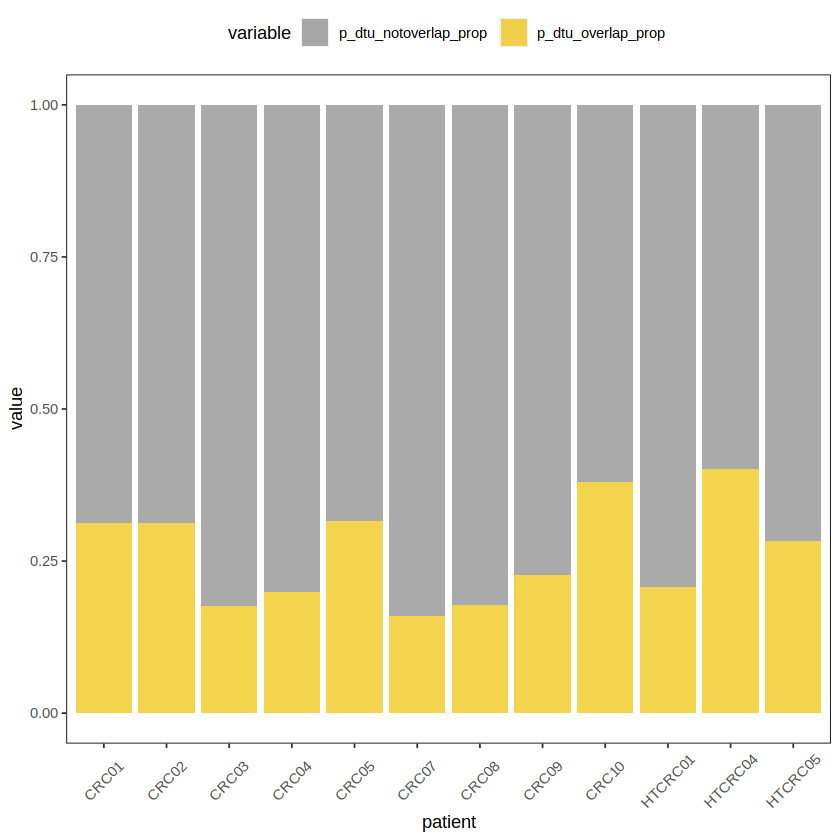

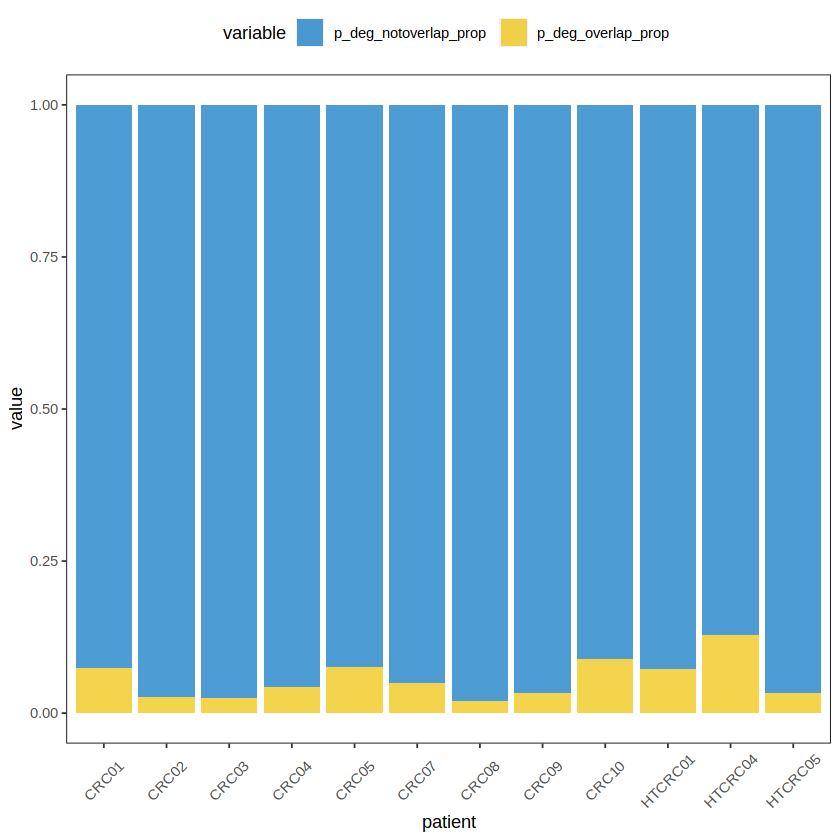

In [111]:
ggplot(df_deg_dtu_bar, aes(x = patient, y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  mytheme +
  scale_fill_manual(values = alpha(c("#868686FF", "#EFC000FF"), 0.7)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), legend.position = "top")
ggsave(file = "03_overlap_DEG_DTUgenes_barplot_DTU.pdf", height = 4.5, width = 3.5)

ggplot(df_deg_deg_bar, aes(x = patient, y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  mytheme +
  scale_fill_manual(values = alpha(c("#0073C2FF", "#EFC000FF"), 0.7)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), legend.position = "top")
ggsave(file = "03_overlap_DEG_DTUgenes_barplot_DEG.pdf", height = 4.5, width = 3.5)

## DTE of each patient

In [112]:
ont <- readRDS(file = "../CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
DefaultAssay(ont) <- "RNA"
ont <- subset(ont, cells = (ont@meta.data %>% filter(celltype3 %in% c("Stem/TA", "Stem/TA-like")))$CellName)
ont_crc <- subset(ont, cells = (ont@meta.data %>% filter(data %in% "CRC"))$CellName)
ont_htcrc <- subset(ont, cells = (ont@meta.data %>% filter(data %in% "HTCRC"))$CellName)

In [114]:
for (i in c(1:12)) {
  p <- names(table(ont@meta.data$patient))[i]
  print(p)
  if (i %in% c(1:9)) {
    ont_p <- subset(ont_crc, cells = c(
      (ont_crc@meta.data %>% filter(celltype3 %in% "Stem/TA"))$CellName,
      (ont_crc@meta.data %>% filter(celltype3 %in% "Stem/TA-like", patient %in% p))$CellName
    ))
  } else {
    ont_p <- subset(ont_htcrc, cells = c(
      (ont_htcrc@meta.data %>% filter(celltype3 %in% "Stem/TA"))$CellName,
      (ont_htcrc@meta.data %>% filter(celltype3 %in% "Stem/TA-like", patient %in% p))$CellName
    ))
  }
  ont_p <- NormalizeData(ont_p, normalization.method = "LogNormalize", scale.factor = 1000000)
  ont_p <- ScaleData(ont_p, features = rownames(ont_p))

  Idents(object = ont_p) <- as.factor(ont_p@meta.data$celltype3)
  dte_p <- FindAllMarkers(ont_p, only.pos = TRUE, min.pct = 0.25, logfc.threshold = log2(2))
  dte_p <- dte_p[which(dte_p$p_val_adj < 0.05), ]
  dte_p$patient <- p

  if (i == 1) {
    dte <- dte_p
  } else {
    dte <- rbind(dte, dte_p)
  }
}

[1] "CRC01"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC02"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC03"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC04"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC05"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC07"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC08"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC09"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "CRC10"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "HTCRC01"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "HTCRC04"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] "HTCRC05"


Centering and scaling data matrix

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



In [115]:
df_dte_dtu <- data.frame(
  patient = character(),
  p_dte_count = integer(),
  p_dtu_count = integer(),
  overlap_count = integer(),
  stringsAsFactors = FALSE
)
for (i in c(1:12)) {
  p <- names(table(ont@meta.data$patient))[i]
  p_dte <- unique((dte %>% filter(patient %in% p))$gene)
  p_dtu <- unique((df_merge_filter %>% filter(patient %in% p))$TranName)
  p_overlap <- length(intersect(p_dte, p_dtu))

  df_dte_dtu <- rbind(df_dte_dtu, data.frame(
    patient = p,
    p_dte_count = length(p_dte),
    p_dtu_count = length(p_dtu),
    overlap_count = p_overlap
  ))
}

In [116]:
df_dte_dtu$patient <- factor(df_dte_dtu$patient, levels = names(table(ont@meta.data$patient)))

df_dte_dtu$p_dtu_notoverlap_prop <- (df_dte_dtu$p_dtu_count - df_dte_dtu$overlap_count) / df_dte_dtu$p_dtu_count
df_dte_dtu$p_dtu_overlap_prop <- df_dte_dtu$overlap_count / df_dte_dtu$p_dtu_count
df_dte_dtu_bar <- melt(df_dte_dtu, id.vars = "patient", measure.vars = c("p_dtu_notoverlap_prop", "p_dtu_overlap_prop"))

df_dte_dtu$p_dte_notoverlap_prop <- (df_dte_dtu$p_dte_count - df_dte_dtu$overlap_count) / df_dte_dtu$p_dte_count
df_dte_dtu$p_dte_overlap_prop <- df_dte_dtu$overlap_count / df_dte_dtu$p_dte_count
df_dte_dte_bar <- melt(df_dte_dtu, id.vars = "patient", measure.vars = c("p_dte_notoverlap_prop", "p_dte_overlap_prop"))

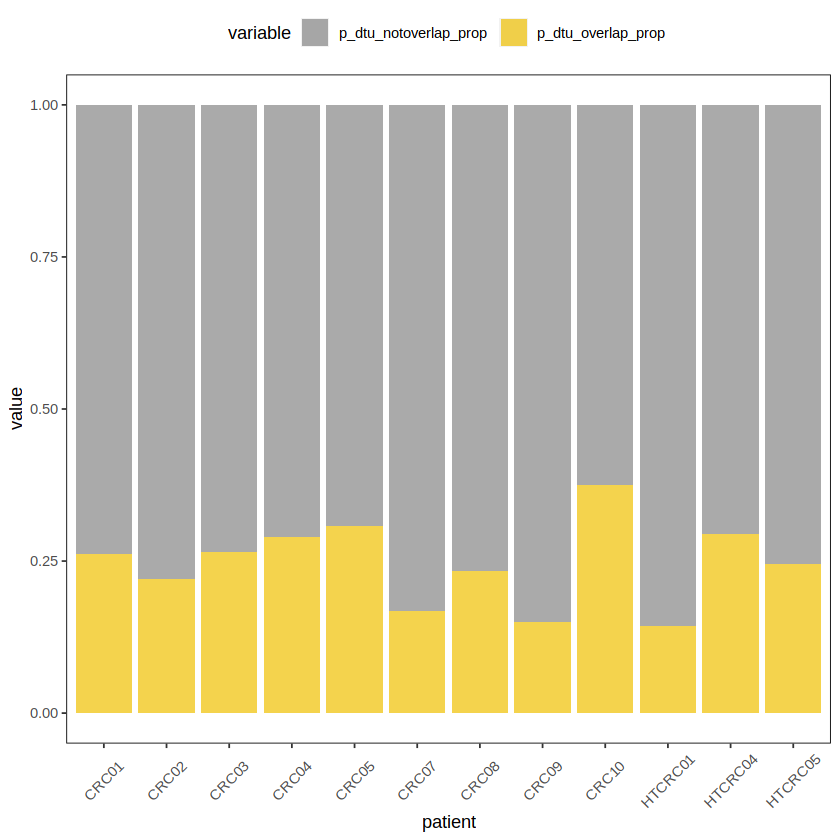

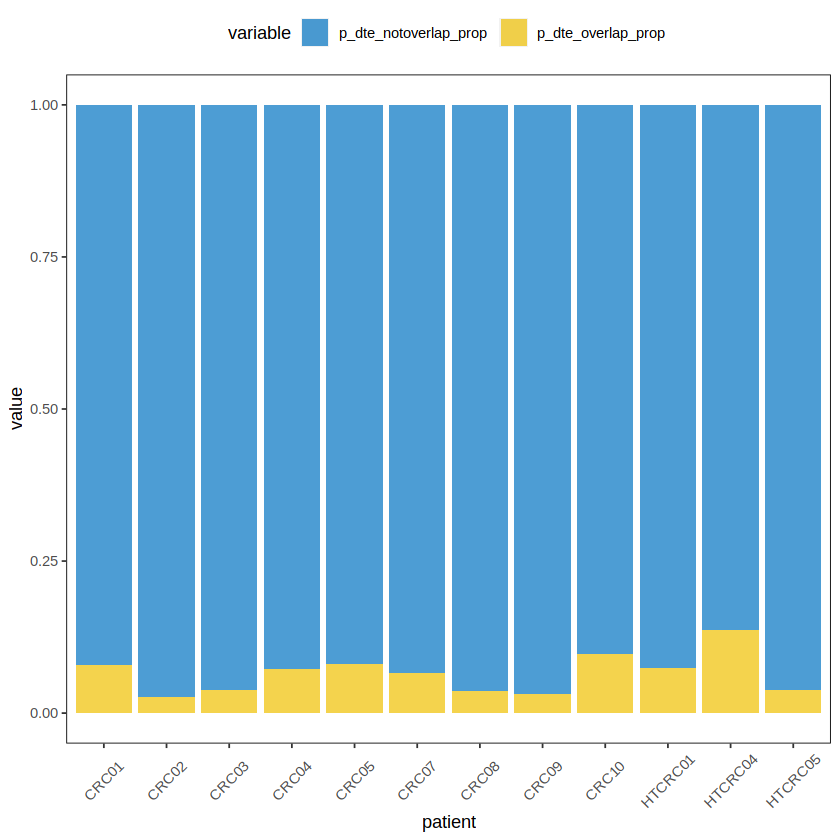

In [118]:
ggplot(df_dte_dtu_bar, aes(x = patient, y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  mytheme +
  scale_fill_manual(values = alpha(c("#868686FF", "#EFC000FF"), 0.7)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), legend.position = "top")
ggsave(file = "03_overlap_DET_DTUgenes_barplot_DTU.pdf", height = 4.5, width = 3.5)

ggplot(df_dte_dte_bar, aes(x = patient, y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  mytheme +
  scale_fill_manual(values = alpha(c("#0073C2FF", "#EFC000FF"), 0.7)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), legend.position = "top")
ggsave(file = "03_overlap_DET_DTUgenes_barplot_DET.pdf", height = 4.5, width = 3.5)

## AS of each patient

In [119]:
df_as <- read.table(file = "../../CRC_HTCRC_11_AS/CRC_HTCRC_01_AS_suppa_each_patient/04_filter_diff_AS_each_patient_rbind.txt", header = T, sep = "\t")

In [120]:
df_as_dtu <- data.frame(
  patient = character(),
  p_as_count = integer(),
  p_dtu_count = integer(),
  overlap_count = integer(),
  stringsAsFactors = FALSE
)
for (i in c(1:12)) {
  p <- names(table(ont@meta.data$patient))[i]
  p_as <- unique((df_as %>% filter(patient %in% p))$gene_id)
  p_dtu <- unique((df_merge_filter %>% filter(patient %in% p))$GeneName)
  p_overlap <- length(intersect(p_as, p_dtu))

  df_as_dtu <- rbind(df_as_dtu, data.frame(
    patient = p,
    p_as_count = length(p_as),
    p_dtu_count = length(p_dtu),
    overlap_count = p_overlap
  ))
}

In [121]:
df_as_dtu$patient <- factor(df_as_dtu$patient, levels = names(table(ont@meta.data$patient)))

df_as_dtu$p_dtu_notoverlap_prop <- (df_as_dtu$p_dtu_count - df_as_dtu$overlap_count) / df_as_dtu$p_dtu_count
df_as_dtu$p_dtu_overlap_prop <- df_as_dtu$overlap_count / df_as_dtu$p_dtu_count
df_as_dtu_bar <- melt(df_as_dtu, id.vars = "patient", measure.vars = c("p_dtu_notoverlap_prop", "p_dtu_overlap_prop"))

df_as_dtu$p_as_notoverlap_prop <- (df_as_dtu$p_as_count - df_as_dtu$overlap_count) / df_as_dtu$p_as_count
df_as_dtu$p_as_overlap_prop <- df_as_dtu$overlap_count / df_as_dtu$p_as_count
df_as_as_bar <- melt(df_as_dtu, id.vars = "patient", measure.vars = c("p_as_notoverlap_prop", "p_as_overlap_prop"))

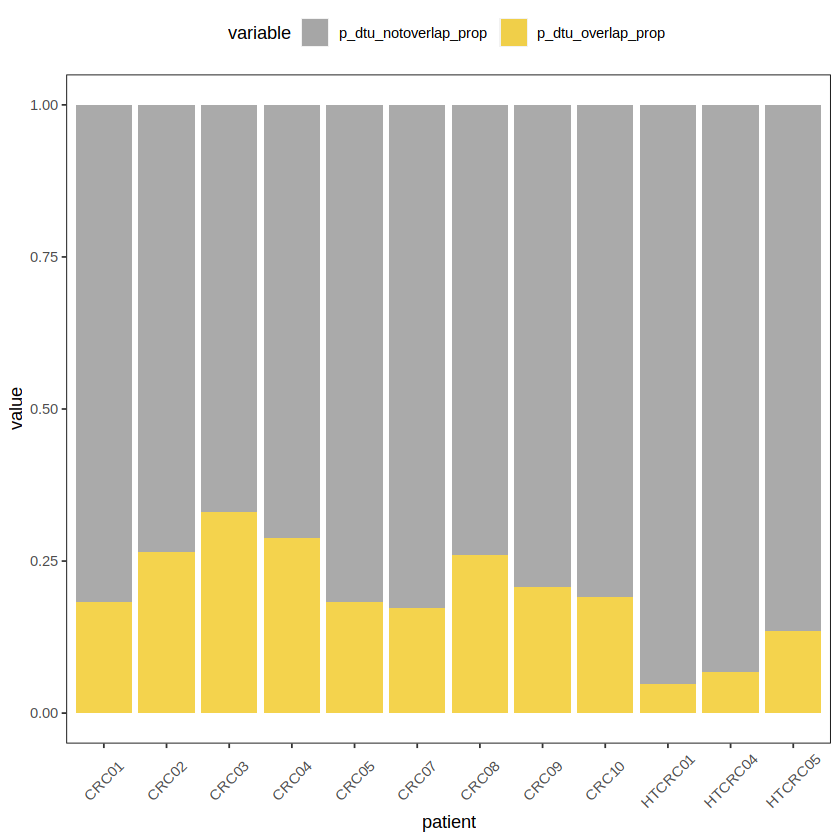

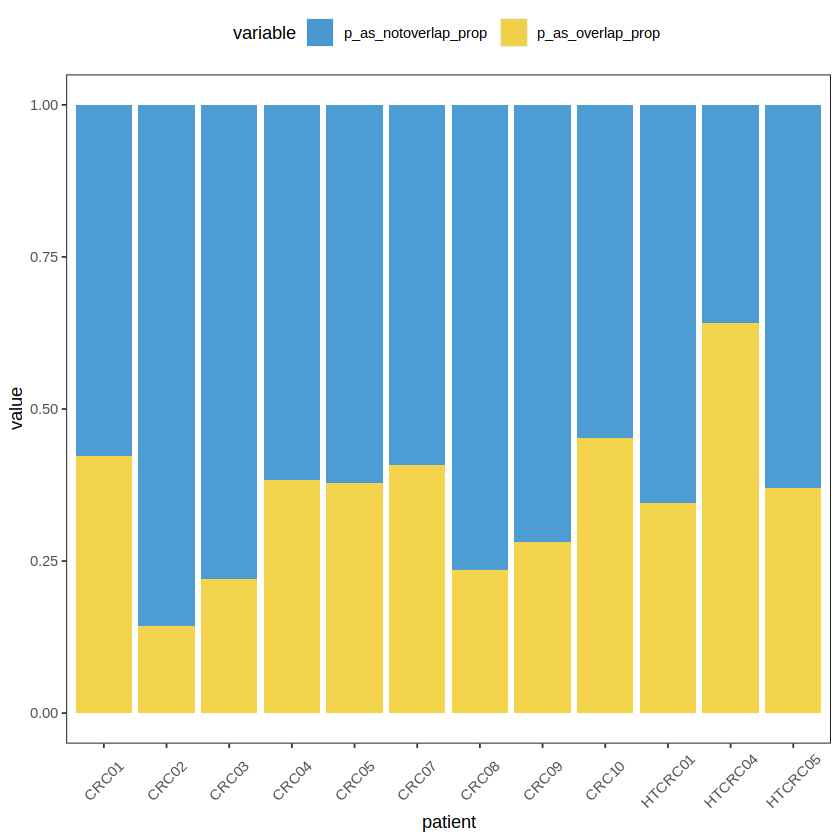

In [123]:
ggplot(df_as_dtu_bar, aes(x = patient, y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  mytheme +
  scale_fill_manual(values = alpha(c("#868686FF", "#EFC000FF"), 0.7)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), legend.position = "top")
ggsave(file = "03_overlap_AS_DTUgenes_barplot_DTU.pdf", height = 4.5, width = 3.5)

ggplot(df_as_as_bar, aes(x = patient, y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  mytheme +
  scale_fill_manual(values = alpha(c("#0073C2FF", "#EFC000FF"), 0.7)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), legend.position = "top")
ggsave(file = "03_overlap_AS_DTUgenes_barplot_AS.pdf", height = 4.5, width = 3.5)

# CDS and protein domains from Pfam

In [124]:
dtu_tx <- read.table(file = "02_DTU_tx_each_patient_final_DTUgenes.txt", header = T, sep = "\t", check.names = F)
dtu_tx$cluster <- "Stem/TA"
dtu_tx[which(dtu_tx$ave_tx_Prop_stemTAlike_minus_stemTA > 0), ]$cluster <- "Stem/TA-like"

In [125]:
for (p in names(table(dtu_tx$patient))) {
  if (!dir.exists(sprintf("04_diff_CDS/%s", p))) {
    dir.create(sprintf("04_diff_CDS/%s", p), recursive = TRUE)
  }
  write.table(dtu_tx %>% filter(patient %in% p), file = sprintf("04_diff_CDS/%s/01_DTU_tx_each_patient_AllInfo_%s.txt", p, p), quote = F, sep = "\t", row.names = F)
}

In [312]:
# /gpfs1/tangfuchou_pkuhpc/tangfuchou_cls/luping/project/ont_iso_crc/2_RNA_CRC/01_RNA_analysis/CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_04_RNA_5400_3262_DTU_StemTA/04_diff_CDS
# do.sh

In [132]:
for (p in names(table(dtu_tx$patient))) {
  cds_diff <- read.table(file = sprintf("04_diff_CDS/%s/4_cds_diff_summary.txt", p), header = F, sep = "\t")
  colnames(cds_diff) <- c("GeneName", "cds_diff_len", "cds_diff_exons")
  mydf <- read.table(file = sprintf("04_diff_CDS/%s/01_DTU_tx_each_patient_AllInfo_%s.txt", p, p), header = T, sep = "\t", check.names = F)
  mydf <- merge(mydf, cds_diff, by = "GeneName", all.x = T)

  pfam_diff <- read.table(file = sprintf("04_diff_CDS/%s/4_cds_diff_in_pfam_summary.txt", p), header = F, sep = "\t")
  colnames(pfam_diff) <- c("GeneName", "cds_diff_pfam_len", "pfam_protein_1", "pfam_protein_2", "pfam_protein_1_numbers", "pfam_protein_2_numbers")
  mydf <- merge(mydf, pfam_diff, by = "GeneName", all.x = T)

  if (p %in% names(table(dtu_tx$patient))[1]) {
    df_merge <- mydf
  } else {
    df_merge <- rbind(df_merge, mydf)
  }
}

In [133]:
df_merge <- df_merge %>% arrange(
  desc(DTU_tx_nPatients_1), desc(DTU_gene_nPatients), desc(max_in_allpatients), desc(abs(`max(Stem/TA-like-Stem/TA)`)), tx_fdr
)

In [134]:
write.table(df_merge, file = "04_DTU_tx_CDS_Pfam.txt", sep = "\t", quote = F, row.names = F)

## CDS change

In [29]:
df_merge <- read.table(file = "04_DTU_tx_CDS_Pfam.txt", sep = "\t", header = T, check.names = F)

In [ ]:
head(df_merge %>% filter(GeneName %in% "SLC25A22"))

,GeneName,TranName,patient,ave_tx_Prop_stemTAlike_minus_stemTA,max_in_allpatients,max(Stem/TA-like-Stem/TA),DTU_tx_nPatients,DTU_gene_nPatients,tx_fdr,gene_qvalue,⋯,P_ave_tx_Prop_stemTAlike_minus_stemTA,DTU_tx_nPatients_1,cluster,cds_diff_len,cds_diff_exons,cds_diff_pfam_len,pfam_protein_1,pfam_protein_2,pfam_protein_1_numbers,pfam_protein_2_numbers
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
1,SLC25A22,SLC25A22-201,CRC07,-0.375,0.5944898,-0.3930141,4,4,0,0.01860190,⋯,-0.366,2,Stem/TA,NA,NA,NA,NA,NA,NA,NA
2,SLC25A22,SLC25A22-228,CRC07,0.375,0.5944898,-0.3930141,4,4,0,0.01860190,⋯,0.366,2,Stem/TA-like,NA,NA,NA,NA,NA,NA,NA
3,SLC25A22,SLC25A22-228,CRC10,0.357,0.5944898,-0.2945259,4,4,0,0.03874157,⋯,0.366,2,Stem/TA-like,NA,NA,NA,NA,NA,NA,NA
4,SLC25A22,SLC25A22-201,CRC10,-0.357,0.5944898,-0.2945259,4,4,0,0.03874157,⋯,-0.366,2,Stem/TA,NA,NA,NA,NA,NA,NA,NA


In [135]:
df_dtu <- df_merge %>% dplyr::distinct(GeneName, .keep_all = TRUE)
df_dtu <- as.data.frame(table(df_dtu$patient))
colnames(df_dtu) <- c("patient", "DTU_genes")

In [136]:
df_cds <- df_merge[!is.na(df_merge$cds_diff_exons), ] %>% dplyr::distinct(GeneName, .keep_all = TRUE)
df_cds <- df_cds[which(df_cds$cds_diff_len >= 20), ]
df_cds <- as.data.frame(table(df_cds$patient))
colnames(df_cds) <- c("patient", "CDS_genes")

In [137]:
df_pfam <- df_merge[!is.na(df_merge$cds_diff_pfam_len), ] %>% dplyr::distinct(GeneName, .keep_all = TRUE)
df_pfam <- df_pfam[which(df_pfam$cds_diff_len >= 20), ]
df_pfam <- as.data.frame(table(df_pfam$patient))
colnames(df_pfam) <- c("patient", "Pfam_genes")

In [138]:
df_freq <- merge(merge(df_dtu, df_cds, by = "patient"), df_pfam, by = "patient")
mean(df_freq$CDS_genes / df_freq$DTU_genes)
mean(df_freq$Pfam_genes / df_freq$CDS_genes)
df_freq

[1] 0.500246

[1] 0.7067136

patient,DTU_genes,CDS_genes,Pfam_genes
<fct>,<int>,<int>,<int>
CRC01,207,114,79
CRC02,29,13,7
CRC03,78,33,26
CRC04,170,83,61
CRC05,213,116,84
CRC07,150,94,67
CRC08,30,17,10
CRC09,53,26,19
CRC10,355,171,119


In [139]:
df_freq$DTU_genes <- df_freq$DTU_genes - df_freq$CDS_genes
df_freq$CDS_genes <- df_freq$CDS_genes - df_freq$Pfam_genes

In [140]:
df_freq <- melt(df_freq, id = c("patient"))
colnames(df_freq) <- c("patient", "class", "count")

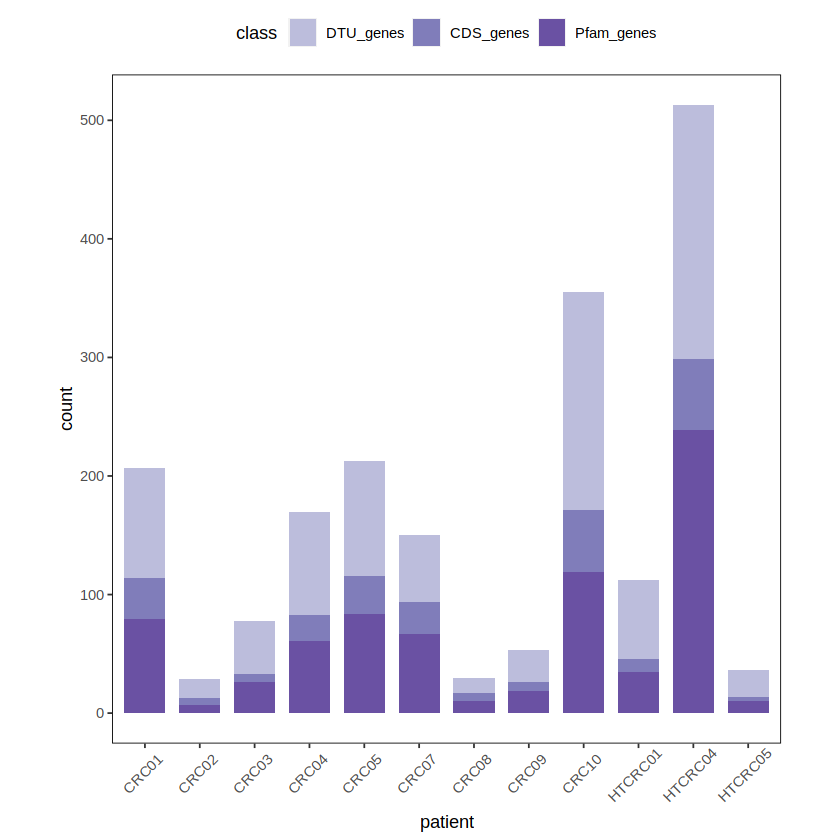

In [141]:
ggplot(df_freq, aes(x = patient, y = count, fill = class, group = class)) +
  geom_bar(stat = "identity", width = 0.75) +
  scale_fill_manual(values = c("#bcbddc", "#807DBA", "#6A51A3")) +
  mytheme +
  theme(aspect.ratio = 1, axis.text.x = element_text(angle = 45, hjust = 0.6, vjust = 0.7), legend.position = "top")
ggsave(file = "04_Venn_barplot_DTUgenes_cds_pfam.pdf", width = 5, height = 4)

In [142]:
df_cds_len <- df_merge[which(df_merge$cds_diff_len >= 20), c("GeneName", "patient", "cds_diff_len", "cds_diff_exons", "cds_diff_pfam_len", "pfam_protein_1", "pfam_protein_2", "pfam_protein_1_numbers", "pfam_protein_2_numbers")]
df_cds_len <- df_cds_len[!duplicated(df_cds_len), ]
dim(df_cds_len)

[1] 1611    9

In [143]:
summary(df_cds_len$cds_diff_len)
summary(df_cds_len$cds_diff_exons)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   21.0   156.0   445.0   885.7  1188.5 17433.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   6.032   8.000  55.000 

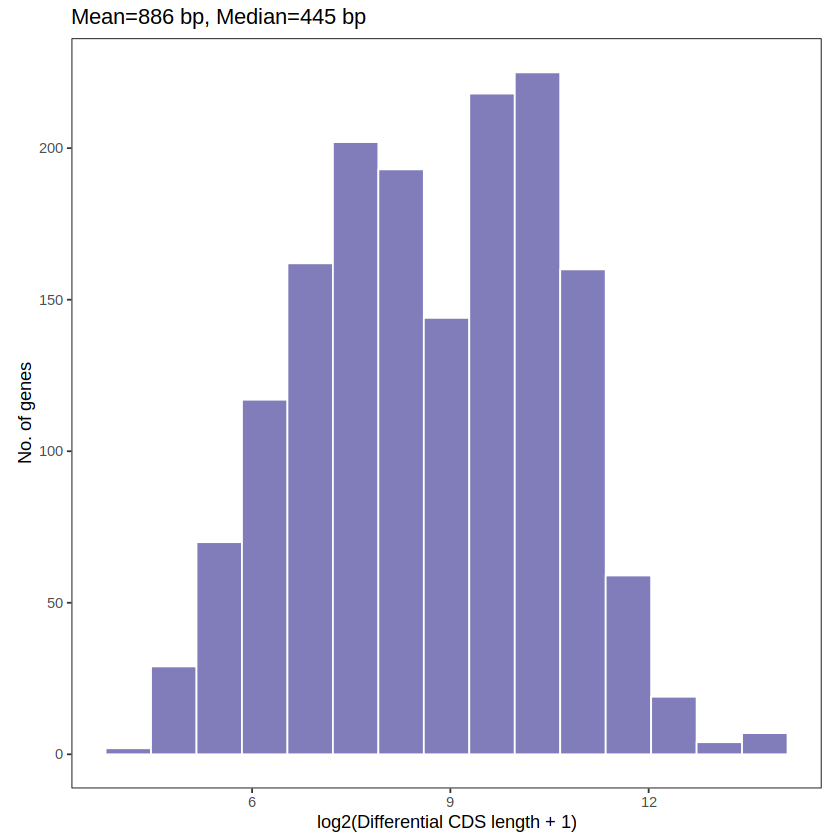

In [145]:
ggplot(df_cds_len, aes(x = log2(cds_diff_len + 1))) +
  geom_histogram(color = "white", fill = "#807DBA", bins = 15) + # geom_vline(xintercept = log2(50 + 1), linetype = "dashed", color = "gray") +
  labs(x = "log2(Differential CDS length + 1)", y = "No. of genes", title = "Mean=886 bp, Median=445 bp") +
  mytheme +
  theme(aspect.ratio = 1)
ggsave(file = "04_diff_CDS_length.pdf", width = 5, height = 4)

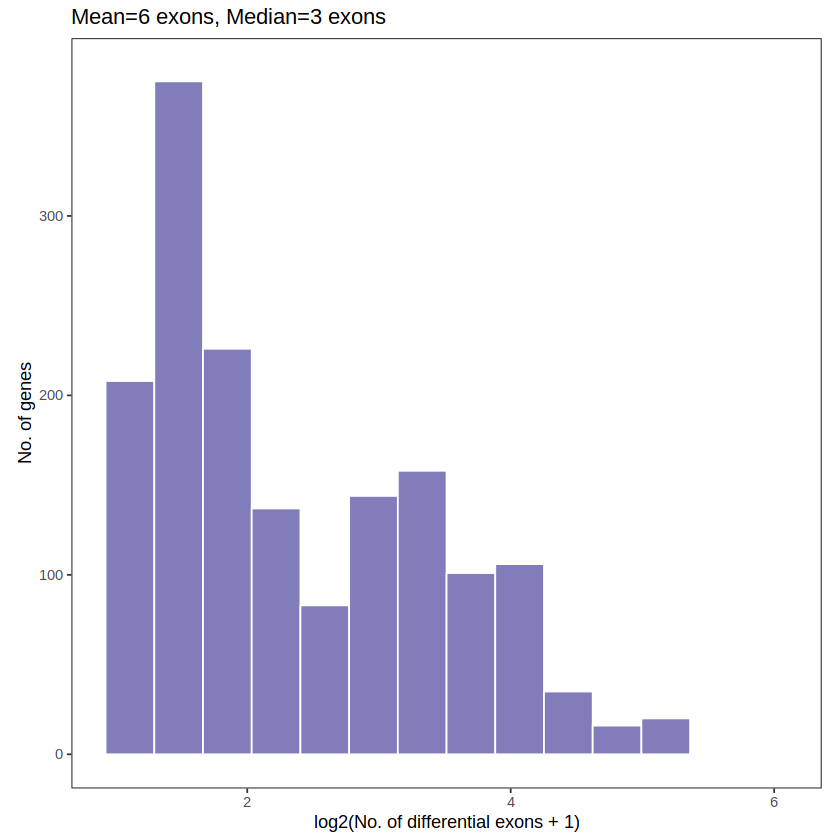

In [149]:
ggplot(df_cds_len, aes(x = log2(cds_diff_exons + 1))) +
  geom_histogram(color = "white", fill = "#807DBA", bins = 14) + # geom_vline(xintercept = log2(50 + 1), linetype = "dashed", color = "gray") +
  labs(x = "log2(No. of differential exons + 1)", y = "No. of genes", title = "Mean=6 exons, Median=3 exons") +
  ylim(0, 380) +
  mytheme +
  theme(aspect.ratio = 1)
ggsave(file = "04_diff_CDS_exons.pdf", width = 5, height = 4)

In [150]:
df_pfam_len <- df_merge[which(df_merge$cds_diff_len >= 20), c("GeneName", "patient", "cds_diff_len", "cds_diff_exons", "cds_diff_pfam_len", "pfam_protein_1", "pfam_protein_2", "pfam_protein_1_numbers", "pfam_protein_2_numbers")]
df_pfam_len <- df_pfam_len[!duplicated(df_pfam_len), ]
dim(df_pfam_len)

[1] 1611    9

In [151]:
summary(df_pfam_len$pfam_protein_1_numbers)
summary(df_pfam_len$pfam_protein_2_numbers)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   1.000   1.828   2.000   9.000     445 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   1.000   2.244   2.000  39.000     445 

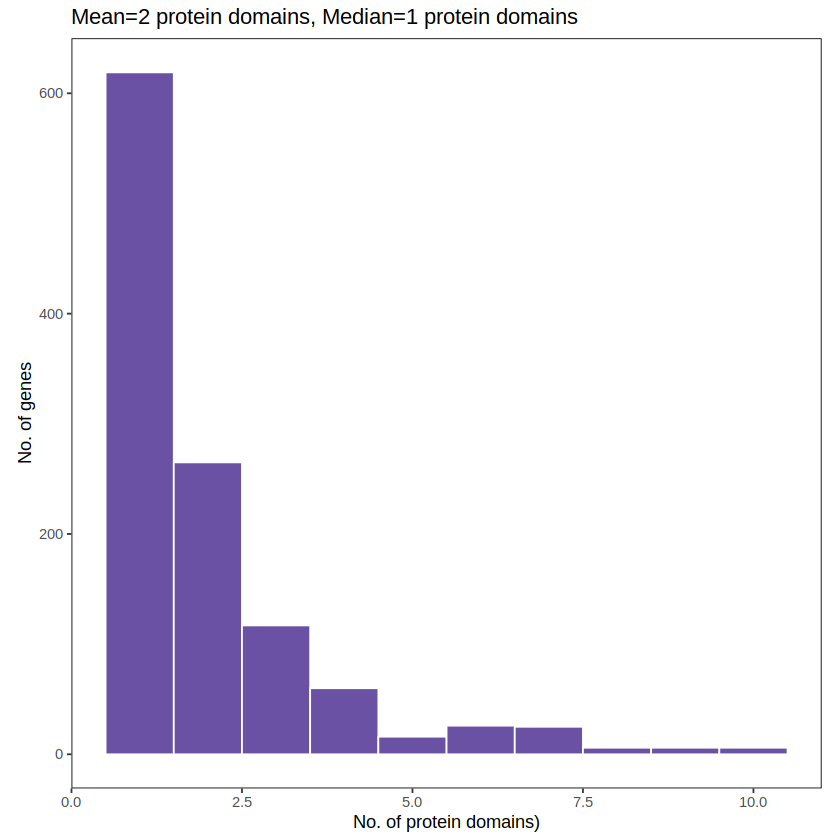

In [152]:
ggplot(df_cds_len %>% filter(pfam_protein_2_numbers <= 10), aes(x = pfam_protein_2_numbers)) +
  geom_histogram(color = "white", fill = "#6a51a3", bins = 10) + # geom_vline(xintercept = log2(50 + 1), linetype = "dashed", color = "gray") +
  labs(x = "No. of protein domains)", y = "No. of genes", title = "Mean=2 protein domains, Median=1 protein domains") +
  mytheme +
  theme(aspect.ratio = 1)
ggsave(file = "04_diff_CDS_Pfam.pdf", width = 5, height = 4)